In [1]:
# imports
import h2o 
import numpy as np
import pandas as pd
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [2]:
# display matplotlib graphics in notebook
%matplotlib inline

In [3]:
# start and connect to h2o server
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpxmj_ouok
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpxmj_ouok/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpxmj_ouok/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster version:,3.14.0.2
H2O cluster version age:,1 month and 22 days
H2O cluster name:,H2O_from_python_phall_8bk9h3
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [4]:
# location of clean data file
path = '/Users/phall/workspace/h2o-tutorials/training/h2o_algos/data/loan.csv'

In [5]:
# define input variable measurement levels 
# strings automatically parsed as enums (nominal)
# numbers automatically parsed as numeric
col_types = {'bad_loan': 'enum'}

In [6]:
frame = h2o.import_file(path=path, col_types=col_types) # import from url

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
frame.describe() # summarize data

Rows:163987
Cols:15




,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,enum,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,,0.0,
mean,13074.169141456332,,13.715904065566178,5.684352932995327,,71915.67051974907,,,15.881530121290096,0.22735700606252826,54.07917280242255,24.579733834274634,,14.854273655448347,
maxs,35000.0,,26.060000000000002,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,,65.0,
sigma,7993.556188734652,,4.391939870545798,3.610663731100237,,59070.91565491826,,,7.587668224192545,0.6941679229284183,25.28536676677049,11.685190365910657,,6.947732922546695,
zeros,0,,0,14248,,0,,,270,139459,1562,0,,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.650000000000002,0.0,83.7,9.0,0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified


In [8]:
# split into 40% training, 30% validation, and 30% test
train, valid, test = frame.split_frame([0.4, 0.3])

In [9]:
# assign target and inputs
y = 'bad_loan'
X = [name for name in frame.columns if name != y]
print(y)
print(X)

bad_loan
['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'revol_util', 'total_acc', 'longest_credit_length', 'verification_status']


In [10]:
# set target to factor - for binary classification
# just to be safe ... 
train[y] = train[y].asfactor()
valid[y] = valid[y].asfactor()
test[y] = test[y].asfactor()

In [11]:
# random forest
# random forest is often best guess model with little tuning

# initialize rf model
rf_model = H2ORandomForestEstimator(
    ntrees=50,                      # Up to 500 decision trees in the forest 
    max_depth=30,                    # trees can grow to depth of 30
    stopping_rounds=5,               # stop after validation error does not decrease for 5 iterations/new trees
    score_each_iteration=True,       # score validation error on every iteration/new tree
    model_id='rf_model',             # for easy lookup in flow
    seed=12345)                      

# train rf model
rf_model.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid)

# print model information
# rf_model

# view detailed results at http://ip:port/flow/index.html

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [12]:
# measure rf AUC
print(rf_model.auc(train=True))
print(rf_model.auc(valid=True))
print(rf_model.model_performance(test_data=test).auc())

0.6555005185496887
0.6787530806751643
0.680813561999385


In [13]:
# GBM is often more accurate the RF, but requires more tuning
# GBM with random hyperparameter search
# train many different GBM models with random hyperparameters
# and select best model based on validation error

# define random grid search parameters
hyper_parameters = {'ntrees':list(range(50, 500, 50)),
                    'max_depth':list(range(2, 20, 2)),
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate':[s/float(10) for s in range(1, 11)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':10,
                   'max_runtime_secs':300}

# initialize grid search
gsearch = H2OGridSearch(H2OXGBoostEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch.train(x=X,
              y=y,
              training_frame=train,
              validation_frame=valid)

# view detailed results at http://ip:port/flow/index.html

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [14]:
# show grid search results
gsearch.show()

# select best model
gbm_model = gsearch.get_grid()[0]

# print model information
gbm_model

    col_sample_rate max_depth ntrees sample_rate  \
0               0.7         2    250         0.6   
1               0.7        10    450         0.7   
2               0.3         8    250         0.9   
3               0.3         8    200         0.6   
4               0.5         4    450         0.1   
5               0.2        16    100         1.0   
6               0.9        12    150         0.8   
7               0.5        16    350         0.8   
8               0.5        12    300         0.4   
9               0.8        16    300         0.5   

                                                           model_ids  \
0  Grid_XGBoost_py_6_sid_ae78_model_python_1507998691868_205_model_8   
1  Grid_XGBoost_py_6_sid_ae78_model_python_1507998691868_205_model_9   
2  Grid_XGBoost_py_6_sid_ae78_model_python_1507998691868_205_model_0   
3  Grid_XGBoost_py_6_sid_ae78_model_python_1507998691868_205_model_3   
4  Grid_XGBoost_py_6_sid_ae78_model_python_1507998691868_205_model_

,0,1,Error,Rate
0,38741.0,14993.0,0.279,(14993.0/53734.0)
1,4736.0,7374.0,0.3911,(4736.0/12110.0)
Total,43477.0,22367.0,0.2996,(19729.0/65844.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2106745,0.4277634,202.0
max f2,0.1247620,0.5801730,286.0
max f0point5,0.3028028,0.4039439,136.0
max accuracy,0.4883325,0.8198317,53.0
max precision,0.8633968,1.0,0.0
max recall,0.0119279,1.0,396.0
max specificity,0.8633968,1.0,0.0
max absolute_mcc,0.2106745,0.2698607,202.0
max min_per_class_accuracy,0.1911987,0.6651096,218.0
max mean_per_class_accuracy,0.1865457,0.6666641,222.0


Gains/Lift Table: Avg response rate: 18.39 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100085,0.5429035,3.5477671,3.5477671,0.6525038,0.6525038,0.0355078,0.0355078,254.7767117,254.7767117
,2,0.0200018,0.4913048,2.8838429,3.2160571,0.5303951,0.5914958,0.0288192,0.0643270,188.3842889,221.6057062
,3,0.0300103,0.4601142,2.5741938,3.0019944,0.4734446,0.5521255,0.0257638,0.0900908,157.4193815,200.1994370
,4,0.0400036,0.4354480,2.5367902,2.8857816,0.4665653,0.5307517,0.0253509,0.1154418,153.6790163,188.5781626
,5,0.0500121,0.4169232,2.6567000,2.8399375,0.4886191,0.5223201,0.0265896,0.1420314,165.6700027,183.9937480
,6,0.1000091,0.3529799,2.2065750,2.5233043,0.4058323,0.4640850,0.1103220,0.2523534,120.6575007,152.3304334
,7,0.1500061,0.3084095,1.8316555,2.2927780,0.3368773,0.4216867,0.0915772,0.3439306,83.1655451,129.2778049
,8,0.2000030,0.2749654,1.5872145,2.1164006,0.2919198,0.3892475,0.0793559,0.4232865,58.7214507,111.6400558
,9,0.2999970,0.2266168,1.3592898,1.8640431,0.25,0.3428340,0.1359207,0.5592073,35.9289843,86.4043096
,10,0.4000061,0.1892138,1.1105512,1.6756558,0.2042521,0.3081859,0.1110652,0.6702725,11.0551155,67.5655806




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1378801676837094
RMSE: 0.3713221885151888
LogLoss: 0.43700082401861967
Mean Per-Class Error: 0.3511826644261655
AUC: 0.7032413981615196
Gini: 0.4064827963230393
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19611620596226523: 


,0,1,Error,Rate
0,26876.0,13057.0,0.327,(13057.0/39933.0)
1,3425.0,5555.0,0.3814,(3425.0/8980.0)
Total,30301.0,18612.0,0.337,(16482.0/48913.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1961162,0.4026529,215.0
max f2,0.1135129,0.5664545,297.0
max f0point5,0.2970180,0.3685852,139.0
max accuracy,0.5880055,0.8174514,25.0
max precision,0.9370301,1.0,0.0
max recall,0.0108805,1.0,396.0
max specificity,0.9370301,1.0,0.0
max absolute_mcc,0.2497686,0.2359822,170.0
max min_per_class_accuracy,0.1873663,0.6451002,223.0
max mean_per_class_accuracy,0.1790670,0.6488173,230.0


Gains/Lift Table: Avg response rate: 18.36 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100178,0.5397931,2.8457179,2.8457179,0.5224490,0.5224490,0.0285078,0.0285078,184.5717922,184.5717922
,2,0.0200151,0.4907960,2.5730669,2.7095317,0.4723926,0.4974464,0.0257238,0.0542316,157.3066938,170.9531680
,3,0.0300125,0.4613254,2.3502906,2.5898662,0.4314928,0.4754768,0.0234967,0.0777283,135.0290580,158.9866218
,4,0.0400098,0.4394701,2.2389024,2.5021701,0.4110429,0.4593766,0.0223831,0.1001114,123.8902401,150.2170098
,5,0.0500072,0.4199594,2.2054859,2.4428575,0.4049080,0.4484873,0.0220490,0.1221604,120.5485947,144.2857527
,6,0.1000143,0.3556436,2.0732000,2.2580287,0.3806214,0.4145544,0.1036748,0.2258352,107.3199961,125.8028744
,7,0.1500010,0.3115424,1.7354278,2.0838759,0.3186094,0.3825814,0.0867483,0.3125835,73.5427831,108.3875925
,8,0.2000082,0.2776015,1.6100146,1.9653985,0.2955846,0.3608300,0.0805122,0.3930958,61.0014578,96.5398479
,9,0.3000020,0.2262710,1.3274756,1.7527720,0.2437129,0.3217936,0.1327394,0.5258352,32.7475628,75.2772020
,10,0.3999959,0.1888034,1.1303589,1.5971767,0.2075240,0.2932277,0.1130290,0.6388641,13.0358861,59.7176683



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2017-10-14 12:37:05,4 min 42.997 sec,0.0,0.5,0.6931472,0.5,1.0,0.8160804,0.5,0.6931472,0.5,1.0,0.8164087
,2017-10-14 12:37:05,4 min 43.132 sec,1.0,0.4426186,0.5834350,0.6479898,1.8173837,0.3056619,0.4426977,0.5835793,0.6453762,1.7898359,0.3089363
,2017-10-14 12:37:05,4 min 43.194 sec,2.0,0.4117668,0.5260304,0.6682373,2.0029378,0.3521961,0.4118458,0.5261771,0.6651287,1.9715795,0.3528714
,2017-10-14 12:37:06,4 min 43.255 sec,3.0,0.3961288,0.4959643,0.6745695,2.1779385,0.3443442,0.3962065,0.4961223,0.6707946,2.0932685,0.3441008
,2017-10-14 12:37:06,4 min 43.323 sec,4.0,0.3866199,0.4763823,0.6834499,2.5274777,0.3175536,0.3866735,0.4765119,0.6805112,2.5264031,0.3426287
---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2017-10-14 12:37:09,4 min 46.356 sec,18.0,0.3721345,0.4387626,0.7009024,2.9202547,0.3313438,0.3728129,0.4407839,0.6939371,2.8639360,0.3353914
,2017-10-14 12:37:09,4 min 46.645 sec,19.0,0.3720020,0.4384444,0.7015340,2.8998183,0.3404866,0.3727297,0.4405674,0.6944353,2.8732025,0.3441825
,2017-10-14 12:37:09,4 min 46.933 sec,20.0,0.3718489,0.4380900,0.7021526,2.8117650,0.3239627,0.3726288,0.4403223,0.6948560,2.9167887,0.3314252
,2017-10-14 12:37:13,4 min 50.940 sec,196.0,0.3667302,0.4264356,0.7262843,3.5230153,0.3088057,0.3712817,0.4369753,0.7032345,2.7679053,0.3397870



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
dti,112.0,1.0,0.1505376
int_rate,108.0,0.9642857,0.1451613
annual_inc,105.0,0.9375,0.1411290
revol_util,96.0,0.8571429,0.1290323
loan_amnt,67.0,0.5982143,0.0900538
total_acc,59.0,0.5267857,0.0793011
longest_credit_length,53.0,0.4732143,0.0712366
addr_state,49.0,0.4375,0.0658602
purpose,41.0,0.3660714,0.0551075
emp_length,25.0,0.2232143,0.0336022


In [15]:
# measure gbm AUC
print(gbm_model.auc(train=True))
print(gbm_model.auc(valid=True))
print(gbm_model.model_performance(test_data=test).auc())

0.7299580222631977
0.7032413981615196
0.7022823257893827


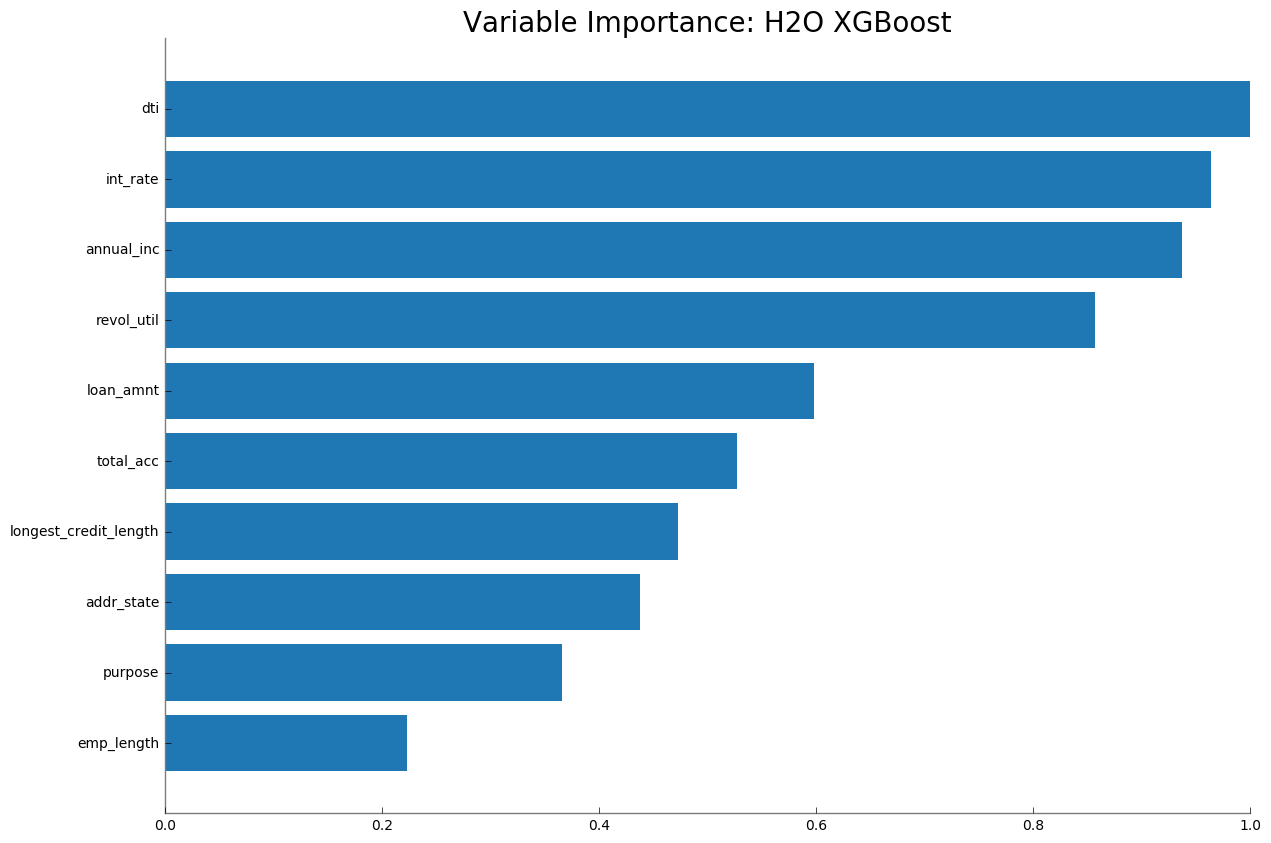

In [16]:
# analyze variable importance
gbm_model.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


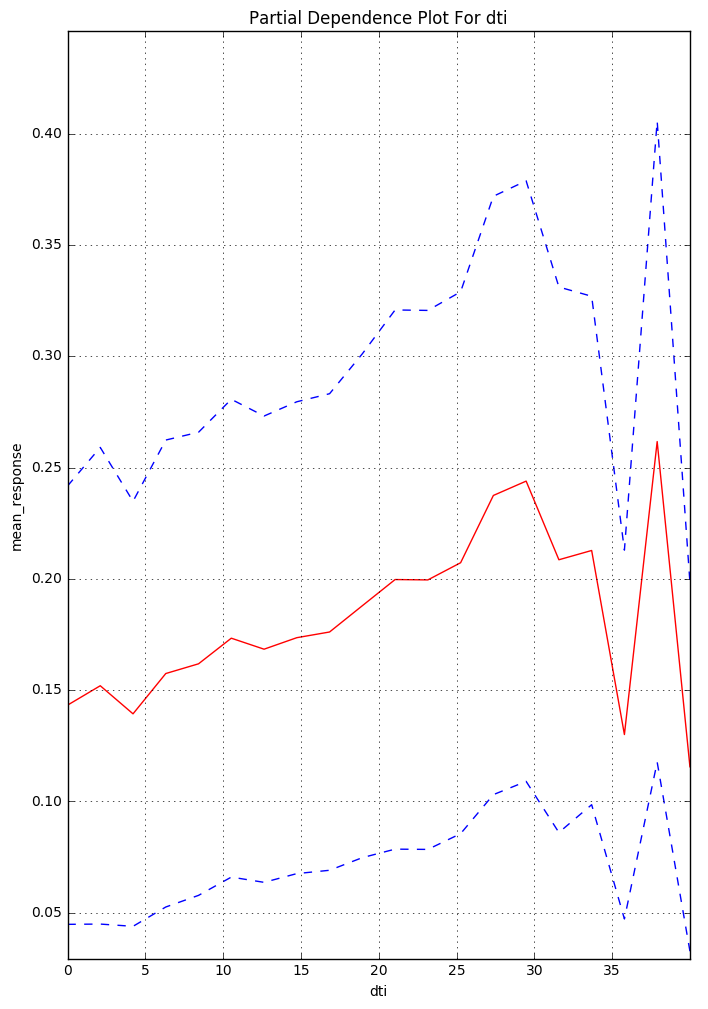

In [17]:
# partial dependence plots are a powerful machine learning interpretation tool
# to calculate partial dependence across the domain a variable
# hold column of interest at constant value
# find the mean prediction of the model with this column constant
# repeat for multiple values of the variable of interest
# h2o has a built-in function for partial dependence as well
par_dep_dti1 = gbm_model.partial_plot(data=train, cols=['dti'], server=True, plot=True)

In [18]:
# shutdown h2o ... be careful this can erase your work
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_ae78 closed.
